<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Univariate-Analysis" data-toc-modified-id="Univariate-Analysis-1">Univariate Analysis</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-3">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-4">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-5">Visualize our data</a></span></li><li><span><a href="#Perform-group-level-analysis" data-toc-modified-id="Perform-group-level-analysis-6">Perform group-level analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

# Univariate Analysis

# Setup
Import Python dependencies necessary to run rest of the code.

In [73]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [15]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Create simulated dataset

In [19]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_subjects = 20
num_conditions = 2
num_voxels = 50
data=[]

normal1 = pm.Normal.dist(mu=1.5,sigma=.5)
normal2 = pm.Normal.dist(mu=.5,sigma=.5)
unif = pm.Uniform.dist(lower=-3,upper=3)
ROI1 = pm.Mixture.dist(w=[.2,.8], comp_dists=[normal1,unif])
ROI2 = pm.Mixture.dist(w=[.2,.8], comp_dists=[normal2,unif])
activations1 = ROI1.random(size=(num_subjects*num_voxels))
activations2 = ROI2.random(size=(num_subjects*num_voxels))

activations = np.concatenate([activations1,activations2])
sub_id = np.tile(np.repeat(np.arange(num_subjects),activations1.size//num_subjects),2)
cond_id = np.concatenate([np.repeat(0,activations1.size),np.repeat(1,activations2.size)])
vox_id = np.tile(np.tile(np.arange(num_voxels),activations1.size//num_voxels),2)

np.save('activations.npy',activations)
np.save('sub_id.npy',sub_id)
np.save('cond_id.npy',cond_id)
np.save('vox_id.npy',vox_id)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [18]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond_id','vox_id']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/univariate/{}.npy'.format(array)).content))

# overview of the data
num_subjects = len(np.unique(sub_id)) #20
num_conditions = len(np.unique(cond_id)) #2
num_voxels = len(np.unique(vox_id)) #50

# Visualize our data

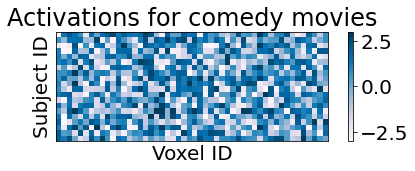

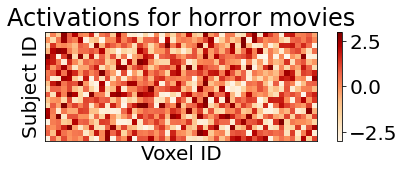

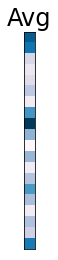

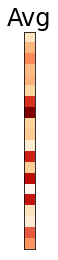

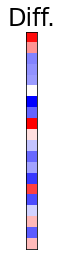

In [20]:
plt.imshow(np.reshape(activations[cond_id==0],(num_subjects,num_voxels)),cmap='PuBu')
plt.colorbar()
plt.title("Activations for comedy movies")
plt.yticks([]);plt.ylabel('Subject ID')
plt.xticks([]);plt.xlabel('Voxel ID')
plt.show()

plt.imshow(np.reshape(activations[cond_id==1],(num_subjects,num_voxels)),cmap='OrRd')
plt.colorbar()
plt.title("Activations for horror movies")
plt.yticks([]);plt.ylabel('Subject ID')
plt.xticks([]);plt.xlabel('Voxel ID')
plt.show()

with plt.rc_context(rc={'figure.figsize': (20,4)}):
    plt.imshow(np.array([np.mean(np.reshape(activations[cond_id==0],(num_subjects,num_voxels)),axis=1)]).T,cmap='PuBu')
    plt.title("Avg")
    plt.yticks([]);plt.xticks([])
    plt.show()

    plt.imshow(np.array([np.mean(np.reshape(activations[cond_id==1],(num_subjects,num_voxels)),axis=1)]).T,cmap='OrRd')
    plt.title("Avg")
    plt.yticks([]);plt.xticks([])
    plt.show()

    diffs=np.array([np.mean(np.reshape(activations[cond_id==0],(num_subjects,num_voxels)),axis=1)]).T - np.array([np.mean(np.reshape(activations[cond_id==1],(num_subjects,num_voxels)),axis=1)]).T
    plt.imshow(diffs,cmap='bwr')
    plt.title("Diff.")
    plt.yticks([]);plt.xticks([])
    plt.show()

In [27]:
# do statistics between conditions
stat = sp.stats.ttest_rel(diffs.flatten(),np.zeros(num_subjects))
print("Horror vs. Comedy (paired t-test):\nt={:.4f}, p={:.4f}".format(stat.statistic,stat.pvalue))

Horror vs. Comedy (paired t-test):
t=1.7043, p=0.1046


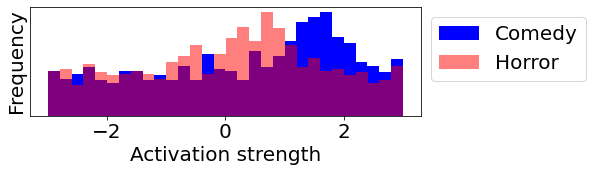

In [101]:
plt.hist(activations[cond_id==0],color='blue',bins=30,label='Comedy')
plt.hist(activations[cond_id==1],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
plt.show()

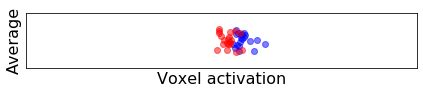

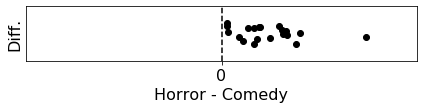

In [93]:
with plt.rc_context(rc={'font.size': 16, 'figure.figsize': (7,1)}):
    jitters = np.random.rand(num_subjects*2)/10
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='b',alpha=.5,label="Horror") 
    plt.scatter(data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[num_subjects:],color='r',alpha=.5,label="Comedy") 
    plt.ylabel('Average')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2e.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean()-data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2f.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

# Perform group-level analysis

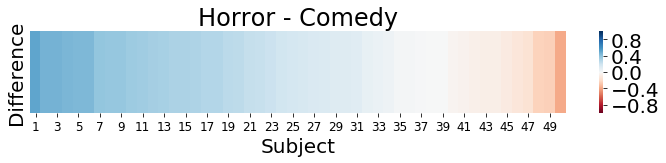

Horror vs. Comedy (paired t-test):
t=5.3904, p=0.0000, d=0.7623


In [110]:
# do statistics between conditions
a=np.mean(np.reshape(data[data['cond']==0]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 0) for every subject
b=np.mean(np.reshape(data[data['cond']==1]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 1) for every subject

with plt.rc_context(rc={'figure.figsize': (12,1.5)}):
    sns.heatmap(np.flip(np.sort([a-b])),vmin=-1,vmax=1,cmap="RdBu")
    plt.ylabel("Difference")
    plt.yticks([])
    plt.xticks(np.arange(.5,num_subjects+.5,2), np.arange(1,num_subjects,2), fontsize=12, rotation=0, ha="center")
    plt.xlabel("Subject")
    plt.title("Horror - Comedy")
    plt.savefig("3.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

stat = sp.stats.ttest_rel(a,b)
print("Horror vs. Comedy (paired t-test):\nt={:.4f}, p={:.4f}, d={:.4f}".format(
    stat.statistic,stat.pvalue,paired_cohen_d(a,b)))

# Conclusion

**ROI responded more to condition 0 (blue) than condition 1 (red)**